# Finding latent trajectories in HDC data

In [2]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


## Load model and dataset <a class="anchor" id="loading"></a>

In [3]:
mice_sessions = {'Mouse12': ['120806']}
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'
bin_size = 50
single_spikes = False
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                    single_spikes, path=data_dir)

units:  85  hdc units:  22


In [4]:
checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 500  # size of time segments of each batch in dataset below

model_dict = {
                'seed': 123, 
                'll_mode': 'U-qd-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-5, 
            }

# model and train/test split based on which validation fold is given by cv_run
modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)


## Compute spike count distributions and tuning curves

In [5]:
# 2D search, so there will be steps**2 = 10000 covariate vector inputs
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(dataset_dict['neurons'])), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

In [6]:
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

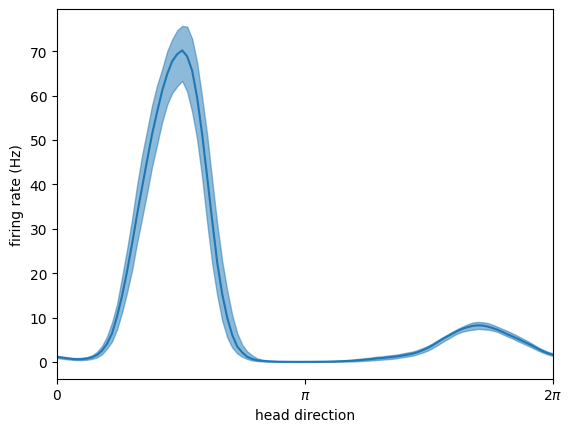

In [7]:
fig, ax = plt.subplots()

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 16  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(),
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('firing rate (Hz)')
ax.set_xlabel('head direction')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
plt.show()

## PCA on head direction tuning curves

[3.68994700e-01 2.49594872e-01 2.03949704e-01 7.67108184e-02
 6.24389630e-02 2.00325817e-02 1.31516706e-02 2.17558923e-03
 1.67038403e-03 4.86437530e-04 3.72536236e-04 1.78076692e-04
 1.27598142e-04 8.74160726e-05 2.18337091e-05 3.08500614e-06
 1.77262856e-06 1.28899224e-06 4.80912035e-07 1.86239778e-07
 4.63473866e-09 2.51131524e-33]
0.8225392762481464


<BarContainer object of 22 artists>

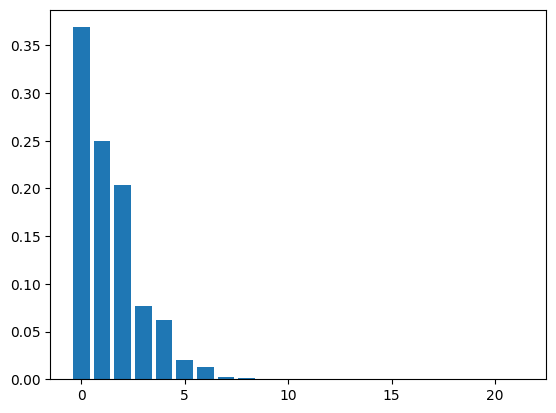

In [8]:
from sklearn.decomposition import PCA
# mean is a matrix [N, T] with N neurons and T samples from tuning curve

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])

pca = PCA()
pca.fit_transform(mean)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(22, 3)


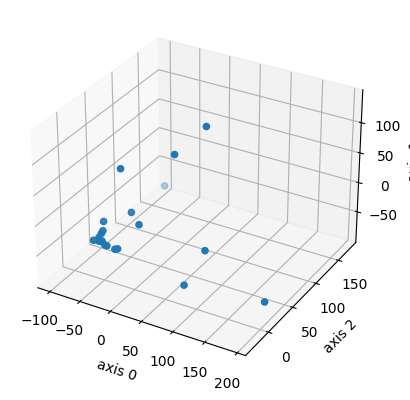

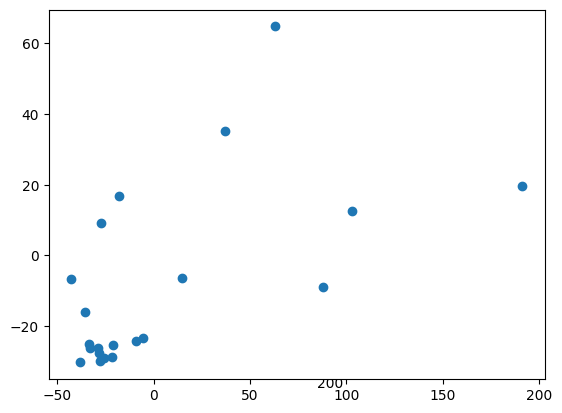

In [9]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(mean)

index = np.where(np.array(principal_components[:,2]) > 150)
print(principal_components.shape)
components = np.delete(principal_components, obj=index, axis=0)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(principal_components[:,0], principal_components[:, 2], principal_components[:, 1])
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 2')
ax.set_zlabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(components[:,0], components[:, 2], components[:, 1])
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 2')
ax.set_zlabel('axis 1')

ax = fig.add_subplot()
ax.scatter(components[:, 0], components[:, 2])

[3.68994700e-01 2.49594872e-01 2.03949704e-01 7.67108184e-02
 6.24389630e-02 2.00325817e-02 1.31516706e-02 2.17558923e-03
 1.67038403e-03 4.86437530e-04 3.72536236e-04 1.78076692e-04
 1.27598142e-04 8.74160726e-05 2.18337091e-05 3.08500614e-06
 1.77262856e-06 1.28899224e-06 4.80912035e-07 1.86239778e-07
 4.63473866e-09 2.51131524e-33]
0.8225392762481464


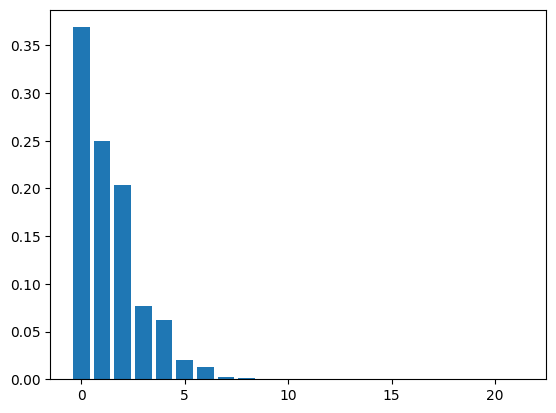

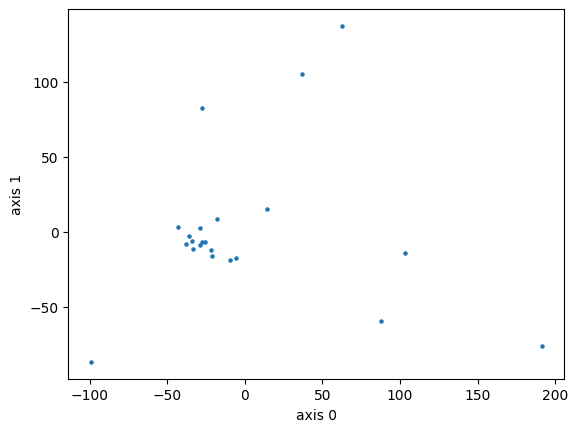

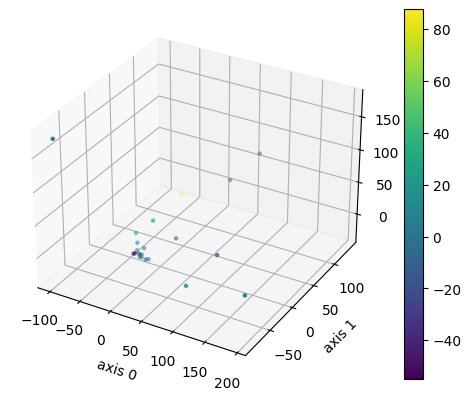

In [10]:
%matplotlib inline

lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate.float(), [0.05, 0.5, 0.95])

pca = PCA()
pca.fit(mean)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

components = pca.transform(mean)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 3], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
fig.colorbar(p)

## PCA on time series SCDs of HD cells

In [27]:
hd_trajectory = torch.tensor(rcov[0])
num_samples = list(hd_trajectory.size())[0]
print('num of time samples ', num_samples)
covariates = torch.cat([
    hd_trajectory[:, None],  # sweep over head direction
    *[rcov[k].mean() * torch.ones((num_samples, 1)) for k in range(1, len(rcov))],
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

num of time samples  43775


In [28]:

# split into chunks of 4000 datapoints
chunk_size = 4000
chunk_num = int(np.ceil(num_samples / chunk_size))
P_mc = None
for i in range(chunk_num):
    print('batch ', i)
    with torch.no_grad():
        P_mc_chunk = lib.helper.compute_P(
            modelfit, covariates[:,:,i*chunk_size:(i+1)*chunk_size, :], list(range(dataset_dict['neurons'])), MC=30,
            trials=1)  # predictive posterior
    P_mc_chunk = P_mc_chunk.cpu()  # count probabilities of shape (MC, neurons, steps, count)
    if P_mc is None:
        P_mc = P_mc_chunk
    else:
        P_mc = np.concatenate((P_mc, P_mc_chunk), axis=2)

batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10


In [29]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz

_, mean, _ = utils.signal.percentiles_from_samples(hd_rate.float(), [0.05, 0.5, 0.95])

print(mean.shape)

torch.Size([22, 43775])


[4.94553033e-01 2.15970880e-01 1.51356687e-01 7.40377791e-02
 3.63248934e-02 1.98993944e-02 4.03097051e-03 1.96630530e-03
 7.33724917e-04 4.22773942e-04 2.96912325e-04 2.15577315e-04
 1.30105957e-04 3.54762193e-05 1.23248815e-05 6.49719123e-06
 3.06443905e-06 2.21594392e-06 8.09010121e-07 5.17884025e-07
 3.51171601e-08 2.15450617e-08]
0.8618806007098202


<BarContainer object of 22 artists>

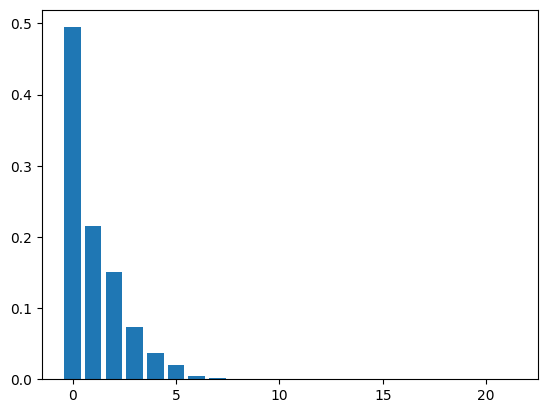

In [30]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(43775, 22)


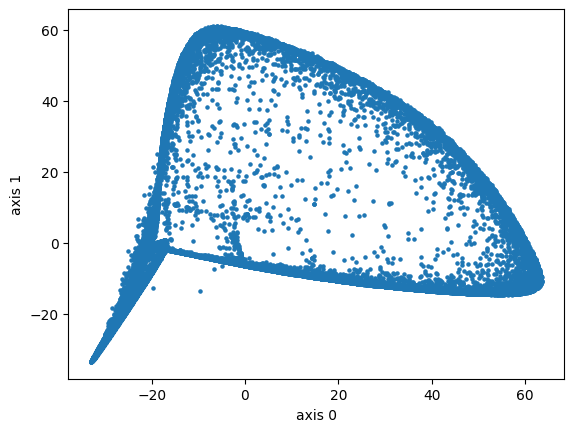

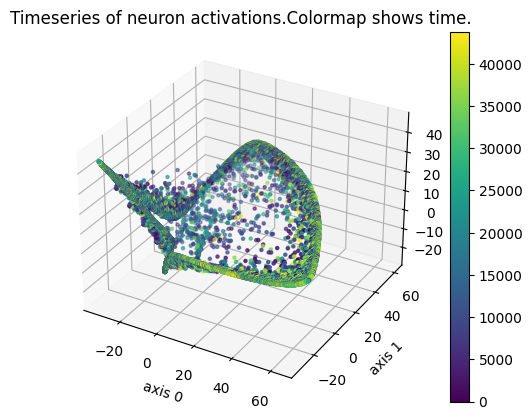

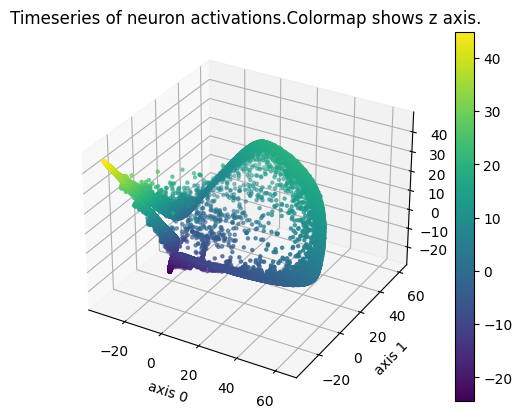

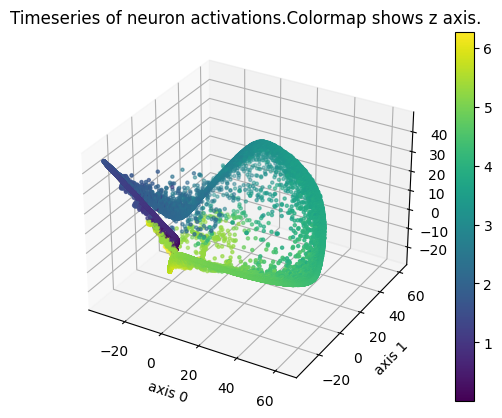

In [31]:
# %matplotlib widget

%matplotlib inline

components = pca.transform(activity)
components_mean = components
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)




tuned_angle = dataset_dict['covariates']['hd']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=tuned_angle, cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)


In [26]:
tuned_angle.shape

(43775,)

## PCA for Fano Factor

In [17]:
%matplotlib inline

In [32]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin'] # in units of Hz
hd_var = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**2 * P_mc).sum(-1)
hd_FF = hd_var / (hd_mean + 1e-12)
_, mean, _ = utils.signal.percentiles_from_samples(hd_FF.float(), [0.05, 0.5, 0.95])

print(mean.shape)

torch.Size([22, 43775])


[3.68693317e-01 2.36163923e-01 1.64822076e-01 1.18621050e-01
 6.13362498e-02 2.65891331e-02 1.19702846e-02 3.93626648e-03
 3.50525614e-03 1.76626428e-03 1.26842722e-03 6.17065687e-04
 3.34924111e-04 1.51965025e-04 1.02151355e-04 6.21334054e-05
 2.14601795e-05 1.66142153e-05 1.03831431e-05 5.10259667e-06
 4.13759361e-06 1.81446005e-06]
0.7696793162291921


<BarContainer object of 22 artists>

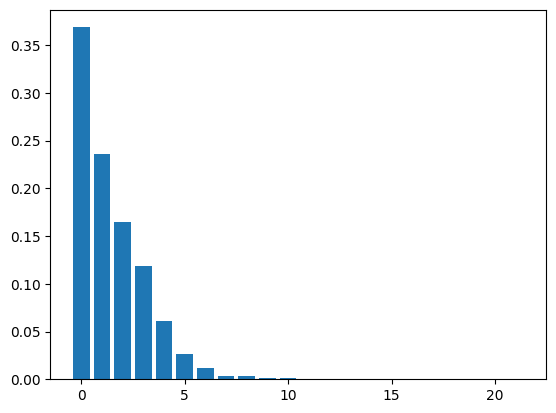

In [33]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(var_explained)
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)



(43775, 22)


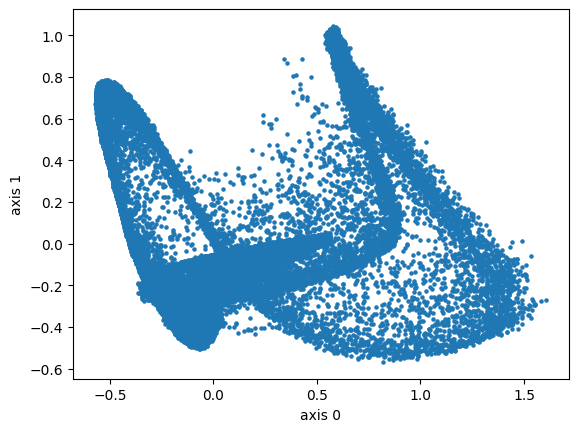

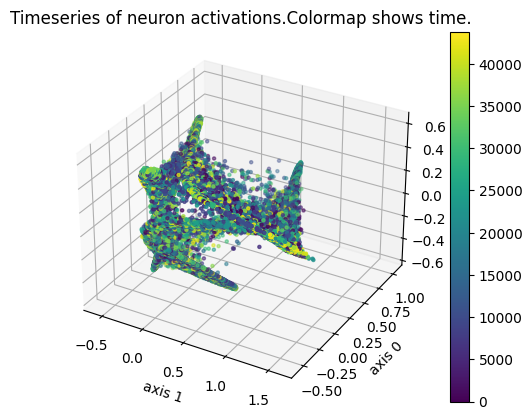

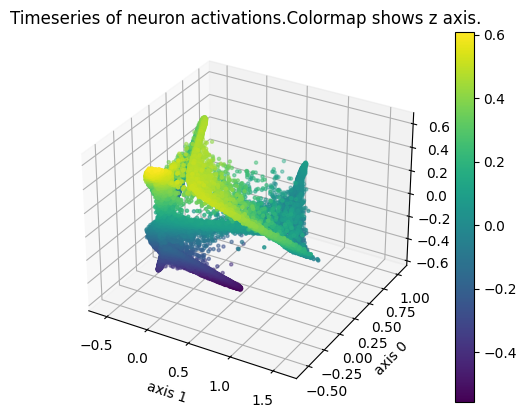

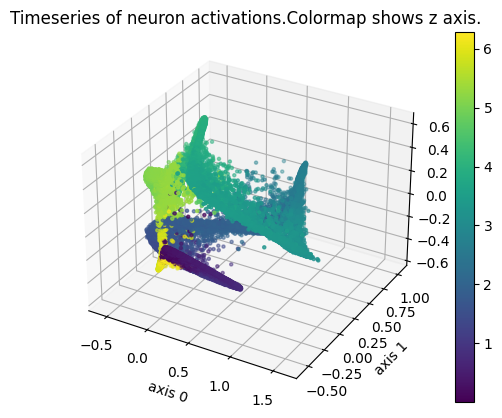

In [34]:
%matplotlib inline
components = pca.transform(activity)

components_FF = components
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)

tuned_angle = dataset_dict['covariates']['hd']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=tuned_angle, cmap='viridis')
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)



## PCA for skewness and kurtosis factors

In [21]:
K = P_mc.shape[-1]
counts = torch.arange(K)
hd_mean = (counts[None, None, None, :] * P_mc.astype(float)).sum(-1)  # (MC, neurons, steps)
hd_var = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**2 * P_mc).sum(-1)
hd_third_moment = ((counts[None, None, None, :] - hd_mean[:,:,:,None])**3 * P_mc).sum(-1)
hd_SF = hd_third_moment / (hd_mean + 1e-12) # skewness factor
_, mean, _ = utils.signal.percentiles_from_samples(hd_SF.float(), [0.05, 0.5, 0.95])


print(mean.shape)

torch.Size([22, 43775])


0.8291489181682269


<BarContainer object of 22 artists>

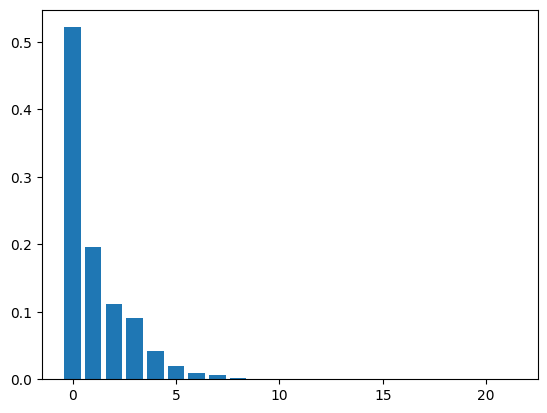

In [22]:
pca = PCA()
activity = torch.transpose(mean, 0, 1)

pca.fit(activity)
var_explained = pca.explained_variance_ratio_
print(np.sum(var_explained[:3]))

plt.bar(np.arange(len(var_explained)), var_explained)

(43775, 22)


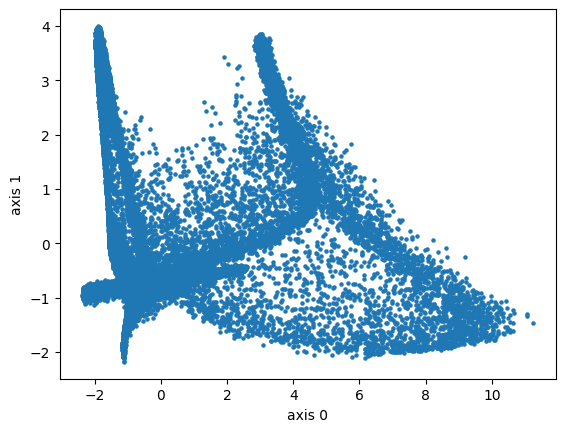

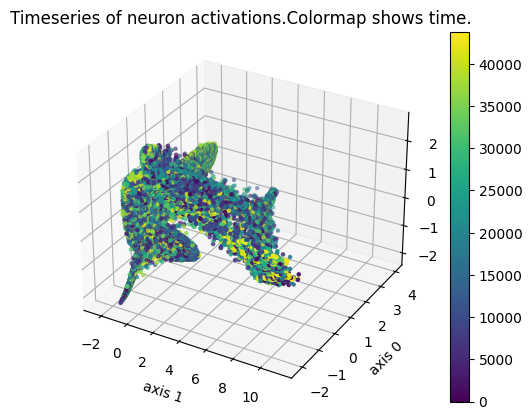

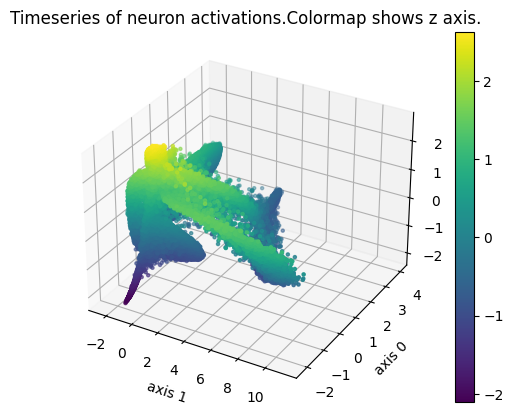

In [23]:
%matplotlib inline
components = pca.transform(activity)
print(components.shape)

fig, ax = plt.subplots()

ax.scatter(components[:, 0], components[:, 1], s=5)
ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=np.arange(components.shape[0]), cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows time.')
fig.colorbar(p)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(components[:,0], components[:, 1], components[:, 2], s=5, c=components[:, 2], cmap='viridis')
ax.set_xlabel('axis 1')
ax.set_ylabel('axis 0')
ax.set_zlabel('axis 2')
ax.set_title('Timeseries of neuron activations.Colormap shows z axis.')
fig.colorbar(p)

# Plot for report

/tmp/ipykernel_16482/1038062584.py:14: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
/tmp/ipykernel_16482/1038062584.py:23: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


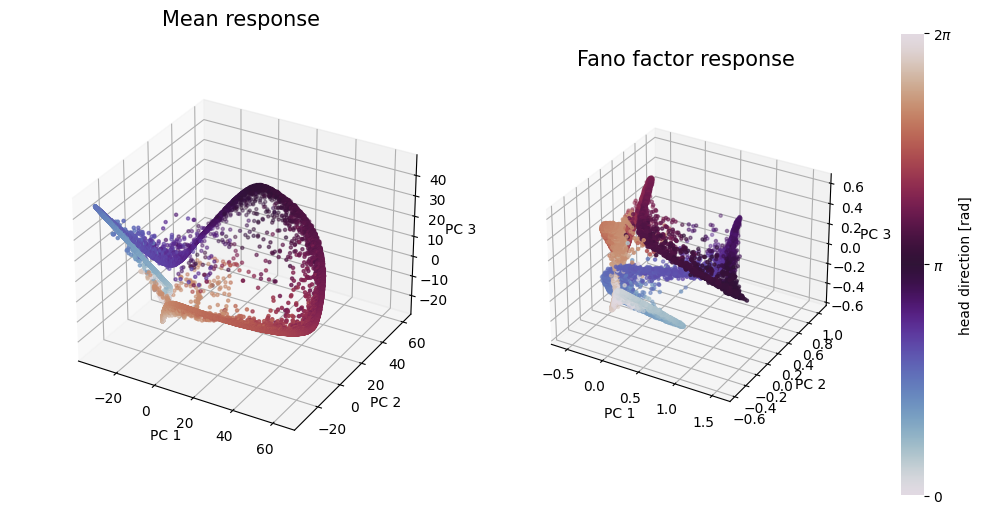

In [40]:
fig = plt.figure(figsize=(10,5))

gs = gridspec.GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0], projection='3d')

tuned_angle = dataset_dict['covariates']['hd']

p = ax.scatter(components_mean[::2,0], components_mean[::2, 1], components_mean[::2, 2], s=5, c=tuned_angle[::2], cmap='twilight')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Mean response', size=15)
ax.dist = 12


ax = fig.add_subplot(gs[1], projection='3d')
p = ax.scatter(components_FF[::3,0], components_FF[::3, 1], components_FF[::3, 2], s=5, c=tuned_angle[::3], cmap='twilight')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Fano factor response', size=15)
ax.dist = 12

fig.tight_layout()
cbar = fig.colorbar(p, ax=ax)
cbar.set_ticks([0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])  # vertically oriented colorbar
cbar.ax.set_ylabel('head direction [rad]')
cbar.outline.set_visible(False)

fig.savefig("/homes/vn283/UCM-interpret/figures/trajectories.pdf", format="pdf", bbox_inches="tight")